In this notebook we reproduce the seminal work "Reconstructing Visual Experiences from Brain Activity Evoked by Natural Movies" (Nishimoto et al, 2011, Current Biology. The code here covers the basics of encoding-decoding studies and may serve as an introductory tutorial if you are thinking of taking your work in this direction. 

## Background

The object here is to try and see if we can predict what is going on in peoples' brain just by looking at their brain activity. This is often referred to as "decoding". To do this we need to develop a method that takes as input the brain activity and produces as an output some description of what was going in their head. In the papers the output was movie frames. 

The experiment we will be analyzing is very simple. Subjects viewed a movie (the stimulus) inside an fMRI scanner. Our method will use this data to build a model that takes in some brain data and predict which part of the stimulus (which frame in the movie) it corresponded to. This can be extended to reconstruct the stimuli from scratch (this tales a little more work so I'll return to it in the end).

The approach has two steps. 

1) Build a model that takes in movie frames and predics brain activity (aka encoding model)
2) Invert the encoding model to take in brain activity and predict the stimulus (dedcoding model)

I will cover the experimental details as I go along, but it would be easier to follow after reading the paper, which you find here. I will link a couple more useful paper in the end. 

## The data

The data from the paper is kindly hosted at https://portal.nersc.gov/project/crcns/download/vim-2. 
You will need to create a free account to access it. 

The VoxelResponses_subject*.tar.gz files contain the brain data. Download and extract them. 

The Stimuli.tar.gz file contains the actual stimulus (the movies) viewed by the subjects. You can download and play the movies (the data is an array of frames). We will not actually directly needs this though, so you don't have to download it. 

### Load the data 

Let's have a look at subject1's data. You would have noticed that the data is a .mat format, which is what matlab uses. We can access it using the h5py package.

The file has four fields.

ei - contains general information about the experiment 
roi - stands for region of interest. These labels tell us which part of the data belongs to what anatomical structure. 
rt - data used for the training the (encoding and decoding) models in the paper
rv - data used for validating the models
rva - data used for validating the models, before averaging. I will explain this later

Lets load the data

In [1]:
import h5py

In [2]:
sn_data_fld = '/mount/nfs5/drorcohen/Nishimoto2011Data/' #path/to/folder/with/data
sn_data_typ = 'VoxelResponses_subject2.mat'
sn_data_fl = sn_data_fld + sn_data_typ

# read the data
with h5py.File(sn_data_fl, 'r') as f:
    
    # these are the things we have here
    print(f.keys())
    
    # validation data, before averaging across trials
    val_data = f['rva'][()]

    # validation data after averaging across trials
    val_data_ave = f['rv'][()]

    # training data
    trn_data = f['rt'][()]

    print("get the roi info")
    ## ROIS
    rois = f['roi']
    print(rois.keys())

    # extra experimental info
    ei = f['ei']
    print(ei.keys())


    # lets get the roi data into a dict
    ei_dict =  {key:ei[key][()][0][0] for key in ei.keys()}
    roi_dict =  {key:rois[key][()] for key in rois.keys()}


<KeysViewHDF5 ['ei', 'roi', 'rt', 'rv', 'rva']>
get the roi info
<KeysViewHDF5 ['EBAlh', 'EBArh', 'MTlh', 'MTprh', 'MTrh', 'OFAlh', 'OFArh', 'RSClh', 'RSCrh', 'VOlh', 'VOrh', 'latocclh', 'latoccrh', 'v1lh', 'v1rh', 'v2lh', 'v2rh', 'v3alh', 'v3arh', 'v3blh', 'v3brh', 'v3lh', 'v3rh', 'v4lh', 'v4rh', 'v7arh', 'v7brh', 'v7crh', 'v7lh', 'v7rh']>
<KeysViewHDF5 ['TRsec', 'datasize', 'imhz', 'valrepnum']>


In [3]:
print(f"training data shape is {trn_data.shape}")
print(f"validation data shape is {val_data.shape} (val_data) and {val_data_ave.shape} (val_data_ave)")

training data shape is (73728, 7200)
validation data shape is (73728, 10, 540) (val_data) and (73728, 540) (val_data_ave)


The train data shape is (73728, 7200) and reflexts voxelsXsamples.
A voxel (volume pixel?) is what we call a 3D "brain pixel". In this experiment each voxel is 2x2x2.5 mm. The 73728 voxels reflect a 64x64x18 "box" which has been flattened to one axis.

In this experiment the temoral resolution of the fMRI is 1 second, so the 7200 samples reflect 7200s (2 hours) of movie viewing.
In total, the training data has 7200 samples of data for each of 73728 voxels. fMRI data is collected over multiple "runs" - short episods of data collection. In this experiment the training data reflects 12 runs of 10 minuntes each (this will be important later).

The val_data shape is (73728, 10, 540). This reflects voxelsXrepeatsXsamples. The validation data shape is different because for the validation experiment the subject watched the same movie 10 times. Averaging over these repeated presentations increases the signal to noise ratio of the brain response and produces better encoding and decoding results then using a single presentation. The val_data variable reflects the unaveraged data, whereas the val_data_ave reflects the same data after averaging over the 10 repeats. We will use the latter.  

<u>Some things to note<u>.

From a modern machine learning perspective, there is actually very little data to work with. However, 7200 is actually lot for an fmri experiment. Most experiment will have a fraction of that. The scarcity of data places constraints on the sort of models we can use. Complex models (such as DNNs) cannot generally be trained end-to-end on this amount of data. For the most part we get around this by using simpler models or pre-trained DNNs.

Raw data that comes of the fMRI machine needs to be processed to deal with things like subject movement in the scanner and alignment of the brain between sessions. fMRI pre-processing is not at all trivial and an ongoing area of research. The data above is already pre-processed (you can see the details in the paper) and I will use it as is. 

If you are like me you are probably itching to get some nice looking brain picture with this data. Unfortunately, doing this requiers a bit more work and is tangential to what I will do here. If you are interested in pursuuing this have a look at the anatomy.zip files. I suggest having a look at nilearn package for getting some quick plots. If you are more serious about this look into pycortex - it's worth suffering through the learning curve. I may cover this kind of thing in the future.

## Check the data

There are many voxels, but some of them may actually reflect non-neuronal matter such as skull. Others may just be corrupt. 
Let's get rid of the bad ones. We will also transpose the data to the more conventional sampsXfeatures format.

In [4]:
import numpy as np

In [5]:
print("check for nans")
# voxels with nan in training data set
train_nans  = np.any(np.isnan(trn_data),axis=1)
# voxels with nan in validation 
val_nans = np.any(np.isnan(val_data.mean(1)),axis=1)
# voxels with nans in either training or validation
train_and_val_nans = train_nans | val_nans

# drop the nan voxels, and tranpose to get samples x features
trn_data_nonan = trn_data[~train_and_val_nans,:].T
val_data_nonan = val_data[~train_and_val_nans,:].transpose(2,1,0)
val_data_ave_nonan = val_data_ave[~train_and_val_nans,:].T
    
# now adjust the rois for the the rejected voxels
roi_dict_nonans = {} 
for roi_key in roi_dict.keys():
    roi_dict_nonans[roi_key] = roi_dict[roi_key].flatten()[~train_and_val_nans]



check for nans


In [6]:
tmps = (f'after nan removal:\nshape of training data is {trn_data_nonan.shape},\
\nshape of val data is {val_data_nonan.shape}\
\nshape of averaged val data is {val_data_ave_nonan.shape}')
print(tmps)

after nan removal:
shape of training data is (7200, 53150),
shape of val data is (540, 10, 53150)
shape of averaged val data is (540, 53150)


I previously mentioned that the val_data_ave_nonan is a the average of val_data_nonan.
Let's check:

In [7]:
print(np.all(np.isclose(val_data_nonan.mean(1).flatten(),val_data_ave_nonan.flatten())))

True


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# import sys
# import scipy as sp
# import pickle as p
# import logging

In [9]:
# # this is where my clone of Alex Huth ridge regression toolbox is (https://github.com/alexhuth/ridge)
# sys.path.insert(0, '/mount/nfs/drorcohen/pystuff/')
# from ridge import ridge, ridge_corr, bootstrap_ridge
# from ridge import utils as ridge_utils



### Basic check of data distribution 

To get a feel for the data let's look at some summary statistics. 
The paper mentions that each voxel was z-scored - mean removed and scaled so standard deviation (std) is one.

#### Figure 1 - Distribution of means and stds

In [46]:
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = "20"

Text(0.5, 1.0, 'VAL data std dist.')

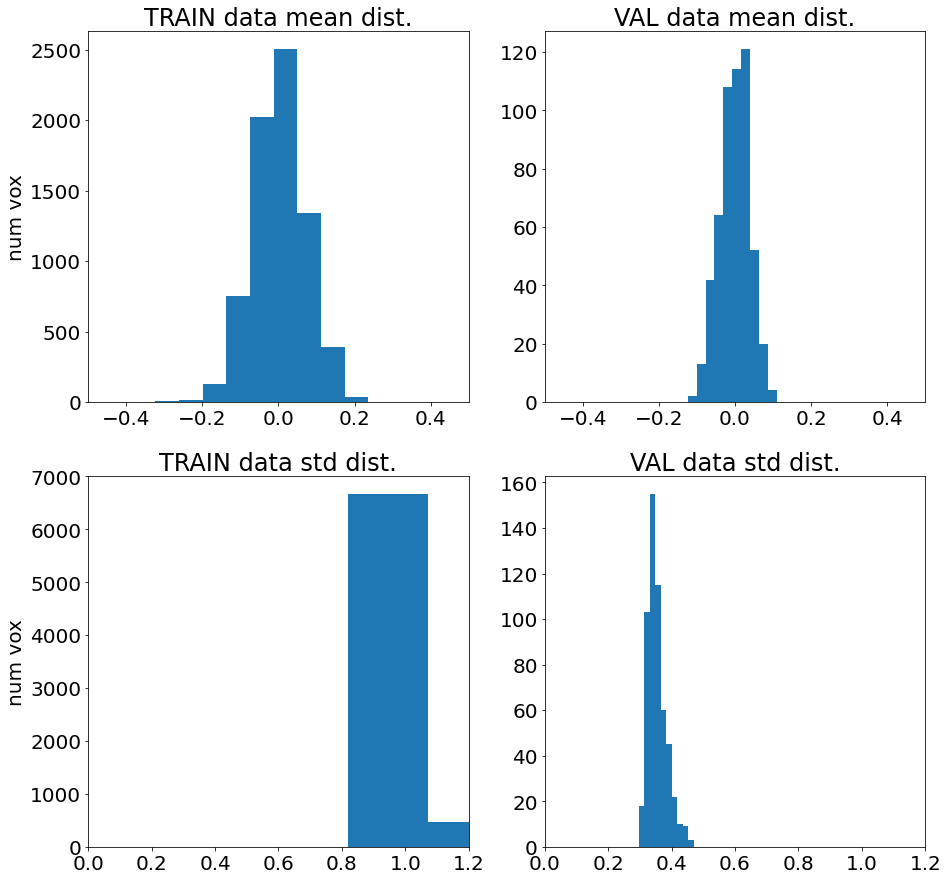

In [48]:
# look at distribution of means
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.ylabel("num vox")
#train data
plt.hist(trn_data_nonan.mean(1));
plt.xlim([-0.5,0.5])
plt.title("TRAIN data mean dist.")
plt.subplot(2,2,2)
#val data
plt.hist(val_data_ave_nonan.mean(1))
plt.xlim([-0.5,0.5])
plt.title("VAL data mean dist.")

# standard deviations
plt.subplot(2,2,3)
#train
plt.hist(trn_data_nonan.std(1));
plt.xlim([0,1.2])
plt.ylabel("num vox")
plt.title("TRAIN data std dist.")
plt.subplot(2,2,4)
#validation
plt.hist(val_data_ave_nonan.std(1))
plt.xlim([0,1.2])
plt.title("VAL data std dist.")

We can see above the the trainind data is indeed roughly zscored (note that in the paper the zscoring is performed for each run seperately whereas here we performed it across all runs). 

Validation data has mean around 0, but std is clearly nowhere near 1. 

Below we zscore the validatioan data

### Zscore the val data

In [12]:
# z-scoring from scipy - always use existing implementaions if possible!
from scipy.stats import zscore

In [13]:
## Zscore the val data
val_data_ave_nonan = zscore(val_data_nonan,axis=0).mean(1)


# Load the stimululs data

The stimulus data proided the repository consists of the movie frames shown to subjects during training and validation.

The whole thing about encoding models is to extract some useful features from this high dimensional data and see if these can be related to the brain response. A bit like feature engineering. 

One of the key contributions of the paper is the introduction of the Motion Energy (ME) features. These are basically spatiotemporal Gabors applied at different frequencies and scales. If you are interested in the details have a look at the supporting information of the paper.

You can compute the motion energy features by putting the raw stimulus through the ME computation. You can find Matlab code here https://github.com/gallantlab/motion_energy_matlab. 

For your convenice I have pre-computed the features and put them up on figshare.

Let's load them.

In [14]:
# My ME estimates are here
ME_fldr = "/mount/nfs5/drorcohen/Nishimoto2011Data/" #path/to/ME/features

In [15]:
# training
fl_typ ="Stimuli_trn_luminance_Gabor_log_downsamp_zscr.mat" 
with h5py.File(ME_fldr + fl_typ,'r') as ME_stim_fl:
    ME_stim_trn = ME_stim_fl.get("S_fin")[()].T

# validation
fl_typ ="Stimuli_val_luminance_Gabor_log_downsamp_zscr.mat" 
with h5py.File(ME_fldr + fl_typ,'r') as ME_stim_fl:
    ME_stim_val = ME_stim_fl.get("S_fin")[()].T

In [16]:
# shapes should match with the neural data
tmps = (f'shape of training data is {ME_stim_trn.shape},\
\nshape of val data is {ME_stim_val.shape}')
print(tmps)

shape of training data is (7200, 6555),
shape of val data is (540, 6555)


The shape of ME_stim_val and ME_stim_trn reflects samplesXfeatures. The 6555 features consists of passing the images through a set of spatio temporal Gabor wavlets with different centers, spatial frequcies, temporal frequencies and orientations.

Now we are ready to built a model that takes the ME as inputs and predict brain responses - our encoding model! 

# Fitting the encoding model

### The secret 
Our encoding model is linear (mic drop). 

That is, we are going to model the response at voxl i time t $r_{it}$ as a linear functions of the stimulus (S, in our case the 6555-dimensional motion energy features) at times $t-k$ to $t-p$. k and p determine how far back we look in order to predict the activity. 

$r_t^i = \sum_{d=p}^{k}S_{t - d} w_{id}$

The objective is to estimate $w_{id}$ for each voxel and delay. 

### What delays shold we use?
fMRI does not reflect direct neuronal activity. Instead, fMRI data, known as BOLD (Blood-oxygen-level-dependent) actualy reflects changes in oxygenated and deoxgenated blood. The theory goes that as neurons start working they use up oxygen and this is reflected in the relative levels of oxygenated and deoxgenated blood. This response is delayed - the BOLD signal peaks 2-6 seconds after the neurons start working. 

In the paper they used delays of 3 to 6 seconds. 

### Regularization
You are probably thinking with 6555*4 features and only 7200 samples we are going to have issues, and you are right. To deal with this we will use regularization. In the paper they used L1, but here I will use L2, aka ridge regression. In my informaal conversations with Shinji Nishimoto about this I learn that L1 can give slightly better results. However the difference is small and ridge is faster to fit (L2 optimization is convex). 

### How to fit
Sklearn and other popular packages all support ridge. I have used them in the past and they are perfectly fine. 
However, Alex Hutz developed his own implementation which is optimized for this kind of thing. In particulr the cross validation procedure uses some tricks and is much quicker than what you'll get out of sklearn (though I admit I never benchmarked it). You can get it from [here](https://github.com/alexhuth/ridge). 

In [103]:
import sys
sys.path.insert(0, '/mount/nfs/drorcohen/pystuff/')
from ridge import ridge_corr, bootstrap_ridge
from ridge.ridge import ridge as fit_ridge
from ridge import utils as ridge_utils

We can use the functionality of this toolbox to stack the stimulis for the desired delays.
That is, take stimulus at times t-3,t-4,t-5 and t-6 and stack them into a 4*6555 long vector

In [18]:
# stack the Stimulus for the selected delays
delays=np.arange(3,6+1)
# train data
ME_stim_trn_dly = ridge_utils.make_delayed(ME_stim_trn,delays)
# val data
ME_stim_val_dly = ridge_utils.make_delayed(ME_stim_val,delays)




## Trimming the data

Before fitting we are going to drop some data. Specificaly, the first few samples from each fMRI run reflect activity from some time before the experiment stated (due to the BOLD delay). In addition, the first few samples may be a bit noise. In the paper they drop the first six samples of each run. 

In [19]:
vols_to_drop = 6
vols_to_drop_inds = np.arange(vols_to_drop)

# trainin data has 12 blocks of 600s
num_runs = 12
blk_sz = trn_data_nonan.shape[0]//num_runs
trn_block_multipliers = np.arange(num_runs)*blk_sz
#use broadcasting to get the inds
trn_inds_to_drp = (vols_to_drop_inds[np.newaxis,:]+trn_block_multipliers[:,np.newaxis]).flatten()
tmp_mask = np.ones(trn_data_nonan.shape[0],dtype=bool)
tmp_mask[trn_inds_to_drp] = False
trn_data_nonan_dly = trn_data_nonan[tmp_mask,:]

# do the same to the stimulus
ME_stim_trn_dly = ME_stim_trn_dly[tmp_mask,:]



The validation data was recorded in one run, so we need to drop the first 6 samples here too. 
However, the validation data consists of 9 chunks of 60s movies. These were actualy randomized during the repeated presentation. For example during the first presentation of the validation data the order of the movies may have been [0,3,5,8,2,7,9,1,4,6], the second presentation [9,5,6,3,1,8,7,4,2,0] etc.

Thankfuly, these all have been aligned in the supplied data. However, due to the BOLD delay, the first few samples at the start of each movie actully correspond to the movie preceeding it. To get passed data we will remove the first 6 samples of each movie 

In [20]:
# can recycle the code from above
num_runs = 9
blk_sz = val_data_ave_nonan.shape[0]//num_runs
val_block_multipliers = np.arange(num_runs)*blk_sz
#use broadcasting to get the inds
val_inds_to_drp = (vols_to_drop_inds[np.newaxis,:]+val_block_multipliers[:,np.newaxis]).flatten()
tmp_mask = np.ones(val_data_ave_nonan.shape[0],dtype=bool)
tmp_mask[val_inds_to_drp] = False
val_data_ave_nonan_dly = val_data_ave_nonan[tmp_mask,:]
ME_stim_val_dly = ME_stim_val_dly[tmp_mask,:]

## Fitting the model using Ridge Regression

## parameters
Finally we can fit the encoding model. We will use cross-validation to estimate the regularization parameters. We will specify the cross validation parameters below.

In [57]:
# this will keep us informed as training proceeds
import logging
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                    level=logging.INFO,
                    stream=sys.stdout)

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# These are all the regularization parameter (alpha) values we'll check
alphas = np.logspace(1, 4, 40)
# number of times we will do the cross validation. These would typically be 15-40. However that can take a long time
# FOR ILLUSTRATION ONLY I will just run this twice
nboots = 2#20

# the cross val works by getting block of contigous data (as opposed to each sample independently).
# How long do we want these blocks to be. Alex Huth recommends having this 3-4 times the delay, which is 6 here
chunklen = 4 * delays[-1] #

# % of hold out data for testing. 
pct_test = 0.1 #10%, same as paper
# the hold out data is actually calculated in number of chunklengs to use. Lets calculate that
# pct_test*(Total number of data)//chunklen.
nchunks_test = int((pct_test)*trn_data_nonan_dly.shape[0]//chunklen) 

# What measure we will use to assess the fit. 
# Classicaly this is the MSE, but in fMRI studies we often use the correlation. I can see argument for and against this, but thats a different topic
use_corr = True

# the logger will tell us how many voxels are above this value. 
# If cross val is workes, this should increase, reach a maximum, and then decrease
corrmin = 0.2

# use seperate alpha for each voxel. The alternative is to use the same alpha for all voxels
single_alpha = False

# set random number generator seed for repeatable results
rng_seed = 1

cv_p = {'alphas':alphas,
        'nboots':nboots,
        'chunklen':chunklen,
        'nchunks':nchunks_test,
        'use_corr':use_corr,
        'single_alpha':single_alpha}  

print(cv_p)

{'alphas': array([   10.        ,    11.93776642,    14.2510267 ,    17.0125428 ,
          20.30917621,    24.24462017,    28.94266125,    34.55107295,
          41.24626383,    49.23882632,    58.78016072,    70.17038287,
          83.76776401,   100.        ,   119.37766417,   142.51026703,
         170.12542799,   203.09176209,   242.44620171,   289.42661247,
         345.51072946,   412.46263829,   492.38826317,   587.80160723,
         701.70382867,   837.67764007,  1000.        ,  1193.77664171,
        1425.1026703 ,  1701.25427985,  2030.9176209 ,  2424.46201708,
        2894.26612472,  3455.10729459,  4124.6263829 ,  4923.88263171,
        5878.01607227,  7017.0382867 ,  8376.77640068, 10000.        ]), 'nboots': 2, 'chunklen': 24, 'nchunks': 29, 'use_corr': True, 'single_alpha': False}


## Do it 

We will use the very convinient *bootstrap_ridge* function to do the cross val for us and fit the model. Heres the important bits from the docstring:

____

bootstrap_ridge(
    Rstim,
    Rresp,
    Pstim,
    Presp,
    alphas,...)
    
Uses ridge regression with a bootstrapped held-out set to get optimal alpha values for each response. The best alpha value for each response will be
averaged across the bootstraps to estimate the best alpha for that response.

<u>Parameters<u>


Rstim : array_like, shape (TR, N)
    Training stimuli with TR time points and N features. Each feature should be Z-scored across time.
    
Rresp : array_like, shape (TR, M)
    Training responses with TR time points and M different responses (voxels, neurons, what-have-you).
    Each response should be Z-scored across time.
    
Pstim : array_like, shape (TP, N)
    Test stimuli with TP time points and N features. Each feature should be Z-scored across time.
    
Presp : array_like, shape (TP, M)
    Test responses with TP time points and M different responses. Each response should be Z-scored across
    time.
    
alphas : list or array_like, shape (A,)
    Ridge parameters that will be tested. Should probably be log-spaced. np.logspace(0, 3, 20) works well.
    

<u>Returns<u>


wt : array_like, shape (N, M)
If [return_wt] is True, regression weights for N features and M responses. If [return_wt] is False, [].

corrs : array_like, shape (M,)
Validation set correlations. Predicted responses for the validation set are obtained using the regression

weights: pred = np.dot(Pstim, wt), and then the correlation between each predicted response and each 
column in Presp is found.

alphas : array_like, shape (M,)
The regularization coefficient (alpha) selected for each voxel using bootstrap cross-validation.

bootstrap_corrs : array_like, shape (A, M, B)
Correlation between predicted and actual responses on randomly held out portions of the training set,
for each of A alphas, M voxels, and B bootstrap samples.

valinds : array_like, shape (TH, B)    
    
___

In [58]:
wt, corr, valphas, bscorrs, valinds = bootstrap_ridge(ME_stim_trn_dly, # training set stimuli
                                              trn_data_nonan_dly, # training set bold response
                                              ME_stim_val_dly, # test set stimuli 
                                              val_data_ave_nonan_dly, # test bold response
                                              **cv_p)



2020-07-30 14:41:28,789 | INFO : Selecting held-out test set..
2020-07-30 14:41:30,083 | INFO : Doing SVD...
2020-07-30 14:42:21,036 | INFO : Dropped 0 tiny singular values.. (U is now (6432, 6432))
2020-07-30 14:42:21,037 | INFO : Training stimulus has LSV norm: 5681.262
2020-07-30 14:42:33,650 | INFO : Average difference between actual & assumed Prespvar: 0.003
2020-07-30 14:42:35,799 | INFO : Training: alpha=10.000, mean corr=0.02654, max corr=0.53972, over-under(0.20)=1668
2020-07-30 14:42:37,893 | INFO : Training: alpha=11.938, mean corr=0.02674, max corr=0.54317, over-under(0.20)=1700
2020-07-30 14:42:39,936 | INFO : Training: alpha=14.251, mean corr=0.02700, max corr=0.54747, over-under(0.20)=1730
2020-07-30 14:42:42,103 | INFO : Training: alpha=17.013, mean corr=0.02732, max corr=0.55269, over-under(0.20)=1777
2020-07-30 14:42:44,070 | INFO : Training: alpha=20.309, mean corr=0.02774, max corr=0.55882, over-under(0.20)=1823
2020-07-30 14:42:46,227 | INFO : Training: alpha=24.24

### Probs a good idea to save righ around here

In [59]:
# tmp save of the model, to avoid training again if/when it crashes
# np.savez("./trained_model.npz"
#          wt=wt,
#          corr=corr,
#          valphas=valphas,
#          bscorrs=bscorrs,
#          valinds=valinds
#         )



### Load saved model

In [60]:
# load
# with np.load("./trained_model_09072020%s.npz"%sn_data_typ[-12:-4]) as f:
#     wt = f['wt']
#     corr = f['corr']
#     valphas = f['valphas']
#     bscorrs = f['bscorrs']
#     valinds = f['valinds']

## Check the cross val

If the cross val identified the peak performance then we shuold see a clear maximum acroos the alpha values

Text(0.5, 0, 'log(alpha)')

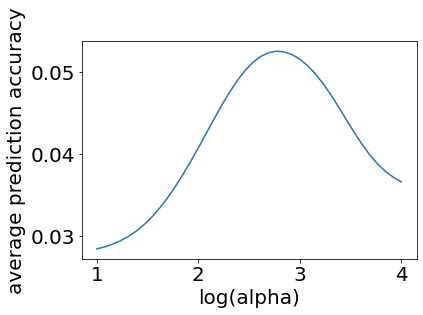

In [61]:
# peak in this graph confirms cross val did what it should
plt.plot(np.log10(alphas),np.mean(bscorrs,axis=(1,2)))
plt.ylabel("average prediction accuracy")
plt.xlabel("log(alpha)")

## Chek - predictio accuracy at two different ROIS 

Let's also look at how the prediction accuracy differs between different brain areas. 
We will look at (1) v1 - the earliest cortical stage of visual processing and (2) V3 a higher level of visual processing. Higher level of visual processing respond to higher level categories. Since the ME features are relativily low level (Gabors), we would expect predictio accuracy to be higher in V1 compared to V3. Let's see.

#### Figure 2

In [62]:
roi1 = 'v1lh' #v1, left hemisphere
roi2 = 'v3lh' #v3, left hemisphere

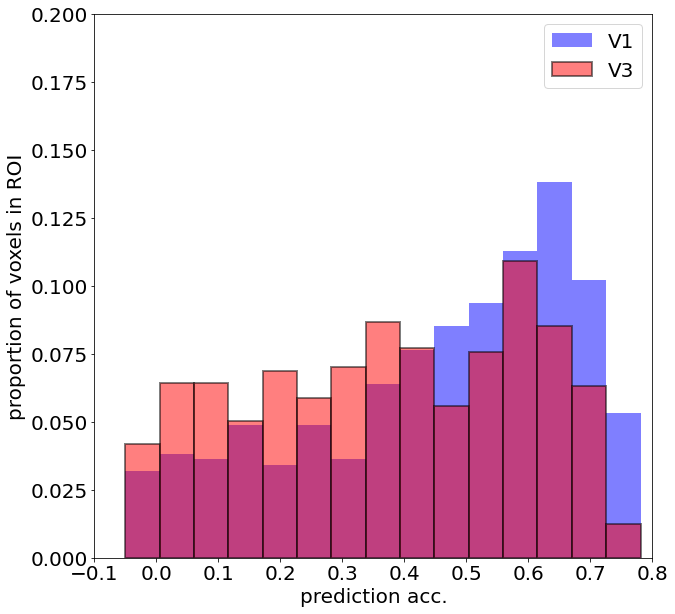

In [64]:
f,ax = plt.subplots(1,1,figsize=(10,10))
roi2chk = roi_dict_nonans[roi1].flatten().astype(np.bool_)
corrs2plt = corr[roi2chk]
# normalize to 1
weights = np.ones_like(corrs2plt) / len(corrs2plt)
# plt.hist(myarray, weights=weights)
counts_bins=ax.hist(corrs2plt,weights=weights,alpha=0.5,color="blue",bins=15);
ax.set_xlim([-0.1,0.8])
ax.set_ylim([0,0.2])
ax.set_ylabel("proportion of voxels in ROI")
ax.set_xlabel("prediction acc.")

roi2chk = roi_dict_nonans[roi2].flatten().astype(np.bool_)
corrs2plt = corr[roi2chk]
# normalize to 1
weights = np.ones_like(corrs2plt) / len(corrs2plt)
# plt.hist(myarray, weights=weights)
ax.hist(corrs2plt,weights=weights,alpha=0.5,color="red",edgecolor="k",linewidth=2,bins=counts_bins[1]);
ax.set_xlabel("prediction acc.")
plt.legend(["V1","V3"],fontsize=20)
# plt.ylabel

As you can see V1 has more voxels with higher accuracy than V3, inline with our expectation. 

# Decoding

## Concept
The idea behind the decoding approach is simple - we invert the decoding model. 

Mathmatically this is the same as the *maximum a posterior estimate*(MAP) under Gaussian assumptions. 

Conceptually, you can think of it as feeding different inputs to the encoding model and choosing the one that best matches the observed brain response. 

## Choosing meaningful voxels
Many parts of the brain are not concerned with motion energy and the prediction accuracy in these parts is low. There is no point using those brain areas in reconstruction. 

Here I will choose best 2000 voxels as assessed using the cross validation accuracy (in the paper they choose the best 2000 out of V1, V2 and V3). This is important because there would be a bit of double dipping if I chose the voxels based on their performance on the test set. 

In [90]:
# number of voxels we will use for reconstruction
N=2000

#cross val predictions accuracy for each alpha
mean_corr_acrossboot = bscorrs.mean(-1)
# location of best alpha for each voxel
best_corr_ind = np.argmax(mean_corr_acrossboot,0)
# get the scores for each voxel at their best alpha
num_voxels = mean_corr_acrossboot.shape[1]
best_corrs_forvox = mean_corr_acrossboot[best_corr_ind,np.arange(num_voxels)]
srt_corrs = np.argsort(best_corrs_forvox)
# the best performing voxels
topN = srt_corrs[-N:]


### Fast log-likelihood/mahalanobis calculation

As I mentioned decoding is based on trying out different candidate inputs and choosing the one that "best" matches the observed response under the encoding model.

So how do we define best? If you properly follow the MAP approach then you find that "best" means likelhood. Under Gaussian assumptions the likelihood is proportional to the mahalanobis distance. For obsreved and estimated brain responses $r$ and $\hat{r}$ the mahalanobis distance is


$\sqrt{(r-\hat{r})\Sigma^{-1}(r-\hat{r})^T}$

We can get $\hat{r}$ with what we already have. $\Sigma$ is the residual covariance matrix and we need to estimate it. We will use a shrunk estimate of the residual covariance matrix. 

The basic idea of shrinking is to increase the strength of the diagonal, thereby making the matrix better conditionned. There are a few options as to how to do it, and I will go with the sklearn implementation.

The shrunk estimate is:

$\Sigma_{\rm
shrunk} = (1-\alpha_{decode})\hat{\Sigma} + \alpha_{decode}\frac{{\rm
Tr}\hat{\Sigma}}{p}\rm Id$

You can read more about this shrunk estimate [here](https://scikit-learn.org/stable/modules/covariance.html). What we need to estimate is $\alpha_{decode}$. We will luse the cross validation for this as well.

In [91]:
from sklearn.covariance import shrunk_covariance

As mentioned we will also want a function of calculating the mahalanobis. Scipy has an inbuilt one. However it is painfully slow. Here we have no choice but to reinvent the wheel (or rather steal a reinvented wheel from stackoverflow. Same diff)

In [92]:
def faster_mahalanobis(x,y,VI):
    """Faster mahalanobis than scipy. Calculates distance between all pairs of x and y.

        Args:
            x (array): Array of vectors, m sambles by k features.
            y (array): Array of vectors, n sambles by k features.
            VI (array): inverse of covariancce matrix used in calculation

        Returns:
            Distance between all pairs in x and y. The array is m by n, distance between x_i and y_j is stored [i,j]

    """
    dist = np.zeros((x.shape[0],y.shape[0]))
    for ind in range(x.shape[0]):
        e = x[ind,:] - y # broadcasting. We can get rid of first for loop as well but that is more difficult to read
        # thank you stackoverflow https://stackoverflow.com/questions/27686240/calculate-mahalanobis-distance-using-numpy-only
        D = np.sqrt(np.sum(np.dot(e,VI) * e, axis = 1)) 
        dist[ind,:]=D
    return dist



### Getting the MAP
This handy function gets the MAP for us - simply choosing the min across the mahalanobis distance array

In [93]:
# this utility function computes the average map estimate given a dist matrix
def MAP_score(dist,axis=1):
    
    """Get the identification accuracy using maximum a posteriori

        Args:
            dist (array): An array of distances between two sets of vectors
            axis (int): The axis along which the predictions are made. Default is 1.
            This means that the distance representes values between the actual observed values in rows, 
            and a bunch of candidate predictions that were used with matching inputs. 

        Returns:
            The average accuracy of the MAP

    """
    # where is the MAP estimate
    MAPs = np.argmin(dist,axis=axis)
    # does it match with the correct value - i.e. does it lie along the diagonal? 
    ave_score = (np.arange(len(MAPs)) == MAPs).mean()
    return ave_score, MAPs

## Use cross vall to estimate the shrinkage parameter

In [94]:
# the shrinkage estimates we will test
shrinkages = np.linspace(0.3, 0.9, 12)

#keep results here
scores = np.zeros((nboots,len(shrinkages)))



We will carry out the CV using the same indicies as the encoding model. It is important to get this right because we do not want information somehow leaking across the folds. 

In [95]:
# use the same CV parameters as the ridge reg
allinds = np.arange(trn_data_nonan_dly.shape[0])
valinds = np.array(valinds)

In [ ]:
for split in range(nboots):
    print(f'split number {split}')
    held_inds = valinds[split,:]
    not_held_inds = np.array(list(set(allinds)-set(held_inds)))
        

    # this splits train and test data
    split_train = trn_data_nonan_dly[np.ix_(not_held_inds,topN)]
    split_test = trn_data_nonan_dly[np.ix_(held_inds,topN)]
    split_ME_train = ME_stim_trn_dly[not_held_inds,:]
    split_ME_test = ME_stim_trn_dly[held_inds,:]
    print(split_ME_train.shape)
    print(split_ME_test.shape)
    
    # retrain the model using the optimal alpha
    split_wt = fit_ridge(split_ME_train, split_train, valphas[topN])
#     Ridge_obj = ridge(valphas[topN], fit_intercept=False, solver='svd')
#     split_wt=Ridge_obj.fit(split_ME_train,split_train).coef_.T
    
    #  model predictions for this split
    split_train_preds = np.dot(split_ME_train,split_wt)  
    split_test_preds = np.dot(split_ME_test,split_wt)  
    
    #this split train residuals
    split_train_error = split_train - split_train_preds
    # this split covariance
    split_cov =  np.cov(split_train_error,rowvar=False)
    
    # try each shrinkage
    print(f'checking shrinkage weight:')
    for cntr2,shrinkage in enumerate(shrinkages):

            #ShrunkCovariance(shrinkage=shrinkage).fit(split_train_error)# split_cov + shrinkage*np.eye(N)
            tmp = shrunk_covariance(split_cov, shrinkage=shrinkage)
            # the corresponding precision
            VI =np.linalg.inv(tmp)
            # get the distance based on this precision
            # The distane from arg1_i to arg2_j is stored in dist[i,j], which here is observedXpredicted 
            dist = faster_mahalanobis(split_test,split_test_preds,VI=VI)
            # get the identification score for this 
            ave_score, MAPs = MAP_score(dist,axis=1)
            print(f'shrink val: {shrinkage:.4f}, score: {ave_score:.4f}')
            scores[split,cntr2] = ave_score
    print("\n")

split number 0
(6432, 26220)
(696, 26220)
checking shrinkage weight:
shrink val: 0.3000, score: 0.4109
shrink val: 0.3545, score: 0.4124


In [40]:
# save them cause the above can take a bit of time
# np.savez("./shrinkage_estimates.npz",
#          num_splits=nboots,
#          shrinkages=shrinkages,
#          scores=scores)
#          test_size=test_size,
#          train_size=train_size,
#          random_states = random_states)

In [41]:
# load
# with np.load("./shrinkage_estimates.npz") as f:
#     num_splits = f['num_splits']
#     shrinkages = f['shrinkages']
#     scores = f['scores']

### Check the shrinkage - do we get a maximum decoding at some intermediate value?

#### Figure 3

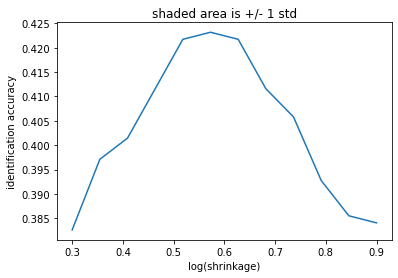

In [43]:
plt.xlabel("log(shrinkage)")
plt.ylabel("identification accuracy")
plt.title("shaded area is +/- 1 std")
scores_mean = scores.mean(0)
plt.plot(shrinkages,scores_mean);
plt.show()

### Use best shrinkage estimate for final calculation of cov matrix

In [44]:
best_shrink = shrinkages[np.argmax(scores_mean)]
# best_shrink = 1.29
print(best_shrink)

# recompute to make sure
train_preds = np.dot(ME_stim_trn_dly,wt[:,topN])  
train_obs = trn_data_nonan_dly[:,topN]

emp_cov =  np.cov(train_obs-train_preds, rowvar=False)
# V = emp_cov + best_shrink*np.eye(N)
VI = ShrunkCovariance(shrinkage=best_shrink,assume_centered=True).fit(train_obs-train_preds).precision_#np.linalg.inv(V)

0.5727272727272728


# Finally, check how well we identify on the validation data set

In [45]:
# get the input and observation for the validation dataset
val_preds = np.dot(ME_stim_val_dly,wt[:,topN])  
val_obs = val_data_ave_nonan_dly[:,topN]

In [46]:
# calculate the distance
dist = faster_mahalanobis(val_obs,val_preds,VI=VI)
# MAP identification erro
val_ave_score, val_MAPs = MAP_score(dist,axis=1)


#### Figure 4

Text(0.5, 1.0, 'MAP accuracy\n58.23% (chance is 0.21)\n+/-1 acc is 90.95%')

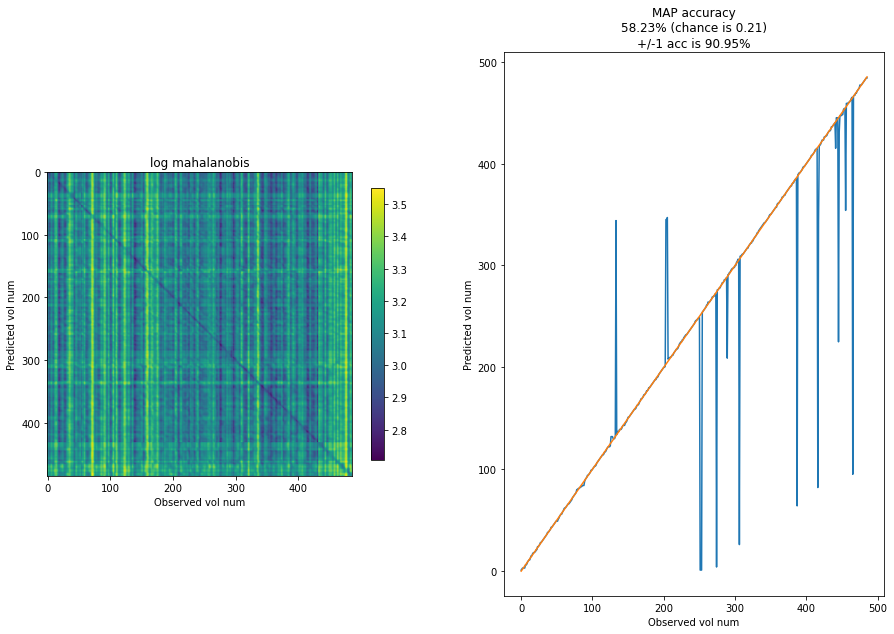

In [47]:
# The distance between all points. 
f,ax = plt.subplots(1,2,figsize=(15,10))
im = ax[0].imshow(np.log(dist.T))
plt.colorbar(im,ax=ax[0], shrink=0.5)
ax[0].set_ylabel("Predicted vol num")
ax[0].set_xlabel("Observed vol num")
ax[0].set_title("log mahalanobis")
# ax[0].scatter(np.arange(val_MAPs.shape[0]),-10-100*correct_vols)

# the identification error
ax[1].plot(np.arange(val_MAPs.shape[0]),val_MAPs)
ax[1].plot(np.arange(val_MAPs.shape[0]),np.arange(val_MAPs.shape[0]))
ax[1].set_ylabel("Predicted vol num")
ax[1].set_xlabel("Observed vol num")
correct_vols = val_MAPs==np.arange(val_MAPs.shape[0])
acc = correct_vols.mean()
# in the paper we also recompute the accuracy when +/- 1 is allowed
distance_to_correct_vol = (np.abs(val_MAPs-np.arange(val_MAPs.shape[0]))<=1)
acc_pm1 = distance_to_correct_vol.mean()
ax[1].set_title(f'MAP accuracy\n{100*acc:.2f}% (chance is {100/val_MAPs.shape[0]:.2f})\n+/-1 acc is {100*acc_pm1:.2f}%')

In [ ]:
stop

In [ ]:
f,ax = plt.subplots(1,1,figsize=(15,10))
im = ax.imshow(np.log(dist.T))
plt.colorbar(im,ax=ax, shrink=0.5)
ax.set_ylabel("Predicted vol num")
ax.set_xlabel("Observed vol num")
ax.set_title("log mahalanobis")
ax.scatter(np.arange(val_MAPs.shape[0]),-10-100*distance_to_correct_vol)

In [ ]:
val_MAPs[~distance_to_correct_vol]

In [ ]:
plt.hist(np.sum(val_data_ave_nonan_dly[np.ix_(np.where(distance_to_correct_vol)[0],topN)]**2,axis=1))
plt.hist(np.sum(val_data_ave_nonan_dly[np.ix_(np.where(~distance_to_correct_vol)[0],topN)]**2,axis=1))

In [ ]:
plt.plot(val_data_ave_nonan_dly[:,topN].mean(1))
plt.scatter(np.where(~correct_vols)[0],val_data_ave_nonan_dly[np.ix_(~correct_vols,topN)].mean(1))

In [ ]:
np.std(val_data_ave_nonan_dly[:,topN],0)